In [ ]:
# default_exp core

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
import numpy as np
from typing import List
import torch.nn as nn
import torch

def shift_bit_eps(bit: int, eps: float = 0.5):
    assert bit in [0,1], "Bit must be 0 or 1"
    return (2 * eps - 1) * bit + 1 - eps

def create_base_vectors(circuit: List[int], eps: float = 0.5):
    vectors = []
    n = len(circuit)
    
    for i in range(n):
        vector = list(circuit).copy()
        vector[i] = shift_bit_eps(vector[i], eps=eps)
        vectors.append(vector)
        
    return vectors

def create_linear_system(vectors: List[List[float]]):
    X = np.array(vectors)

    y = -X[:,-1]

    X[:,-1] = 1
    
    return X,y

class BitComparison(nn.Module):
    def __init__(self,target: List[int], eps : float = 0.5):
        super(BitComparison, self).__init__()
                
        vectors = create_base_vectors(target, eps=eps)
        X,y = create_linear_system(vectors)
        W = np.linalg.solve(X,y)
        w = W[:-1]
        w = np.concatenate([w,np.ones(1)])
        c = W[-1]
        
        if not target[-1]:
            w = -w
            c = -c
            
        n = len(target)
        self.n = n
        self.linear = nn.Linear(n,1)
        
        self.linear.weight.data = torch.tensor(w.reshape(1,-1)).float()
        self.linear.bias.data = torch.tensor(c).unsqueeze(0).float()
        
    def forward(self,x):
        return self.linear(x)
        
    def __repr__(self):
        output = ""
        for i in range(self.n):
            if i < self.n - 1:
                output += f"{self.linear.weight.data[0][i]}*x_{i} + "
            else:
                output += f"{self.linear.weight.data[0][i]}*y + "
        output += f"{self.linear.bias.data[0]} = 0"
        return output

In [ ]:
# export
import itertools

def create_test_cases_x(n):
    products = [[0,1]] * n

    x = list(itertools.product(*products))
    x = np.array(x)
    
    return x

def create_test_cases_y(x,target):
    y = ((x == target).sum(axis=1) == n).astype(int)
    return y

In [ ]:
eps = 0.25
n = 5

x = create_test_cases_x(n)

for target in x:
    y = create_test_cases_y(x,target)
    y = torch.tensor(y)
    
    bitcomparison = BitComparison(target, eps=eps)
    accuracy = (y == (bitcomparison.linear(torch.tensor(x).float()) > 0).view(-1)).float().mean().item()
    
    assert accuracy == 1, f"Accuracy inferior to 1 {accuracy}"

In [ ]:
print(bitcomparison)

1.0*x_0 + 1.0*x_1 + 1.0*x_2 + 1.0*x_3 + 1.0*y + -4.25 = 0


In [ ]:
from numpy.polynomial.chebyshev import Chebyshev
import matplotlib.pyplot as plt

C:\Users\Daniel\Anaconda3\envs\emd\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


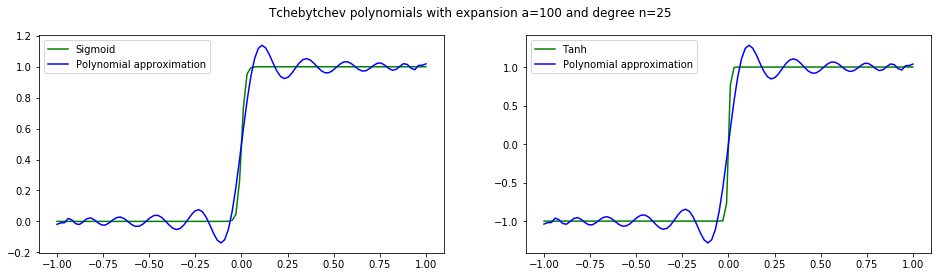

In [ ]:
a = 100
n = 25
A = 1
domain = [-A,A]

sigmoid_a = lambda x: torch.sigmoid(torch.tensor(x*a))
p_sigmoid = Chebyshev.interpolate(sigmoid_a,deg=n,domain=domain)

tanh_a = lambda x: torch.tanh(torch.tensor(x*a))
p_tanh = Chebyshev.interpolate(tanh_a, deg=n, domain=domain)

x = np.linspace(*domain,100)
y1 = sigmoid_a(x)
pred1 = p_sigmoid(x)

y2 = tanh_a(x)
pred2 = p_tanh(x)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# plot the function
ax1.plot(x,y1, 'g', label="Sigmoid")
ax1.plot(x,pred1,"b-", label=f"Polynomial approximation")
ax1.legend()

# plot the function
ax2.plot(x,y2, 'g', label="Tanh")
ax2.plot(x,pred2,"b-", label=f"Polynomial approximation")
ax2.legend()

# show the plot
fig.suptitle(f"Tchebytchev polynomials with expansion a={a} and degree n={n}")
fig.show()

In [ ]:
eps = 0.005

x = torch.linspace(-eps,eps,)
delta_x = x[1] - x[0]

l_sigmoid = torch.norm(p_sigmoid(x) - sigmoid_a(x))
l_tanh = torch.norm(p_tanh(x) - tanh_a(x))

print(f"Loss of sigmoid : {l_sigmoid}")
print(f"Loss of tanh : {l_tanh}")

a,b = len(x) // 2 - len(x) // 4, len(x) // 2 + len(x) // 4

def derivative(f,x,i,delta_x):
    output = (f(x[i+1]) - f(x[i])) / delta_x
    return output

derivatives_tanh = []
derivatives_sigmoid = []

for i in range(a,b):
    derivatives_sigmoid.append(derivative(p_sigmoid,x,i,delta_x))
    derivatives_tanh.append(derivative(p_tanh,x,i,delta_x))
    
print(f"Mean derivative of sigmoid : {torch.tensor(derivatives_sigmoid).mean()}")
print(f"Mean derivative of tanh : {torch.tensor(derivatives_tanh).mean()}")

saturation = 0.9
precision = 1e-3

i = 0
while p_sigmoid(i * precision) <= saturation:
    i += 1
print(f"Saturation point of {saturation} for sigmoid : {i} * {precision}")

i = 0
while p_tanh(i * precision) <= saturation:
    i += 1
print(f"Saturation point of {saturation} for tanh : {i} * {precision}")

C:\Users\Daniel\Anaconda3\envs\emd\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\Daniel\Anaconda3\envs\emd\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Loss of sigmoid : 0.4401373267173767
Loss of tanh : 2.215545177459717
Mean derivative of sigmoid : 9.595970153808594
Mean derivative of tanh : 19.291946411132812
Saturation point of 0.9 for sigmoid : 46 * 0.001
Saturation point of 0.9 for tanh : 53 * 0.001


In [ ]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train = scaler.fit_transform(X_train)

estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
estimator.fit(X_train, y_train)

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
        
print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 13 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 0.2916666641831398 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 2] <= 0.6637930870056152 else to node 8.
		node=3 test node: go to node 4 if X[:, 3] <= 0.6458333432674408 else to node 5.
			node=4 leaf node.
			node=5 test node: go to node 6 if X[:, 1] <= 0.4583333283662796 else to node 7.
				node=6 leaf node.
				node=7 leaf node.
		node=8 test node: go to node 9 if X[:, 3] <= 0.6875 else to node 12.
			node=9 test node: go to node 10 if X[:, 3] <= 0.6458333432674408 else to node 11.
				node=10 leaf node.
				node=11 leaf node.
			node=12 leaf node.



In [ ]:
b = a

In [ ]:
# export
def create_parent_of(n_nodes, is_leaves, children_left, children_right):
    parentOf = {}

    for i in range(n_nodes):
        if not is_leaves[i]:
            parentOf[children_left[i]] = (i,0)
            parentOf[children_right[i]] = (i,1)
    return parentOf

In [ ]:
idx2nodes = [i for i,isLeaf in enumerate(is_leaves) if not isLeaf]
nodes2idx = {node : i for i, node in enumerate(idx2nodes)}

idx2leaves = [i for i,isLeaf in enumerate(is_leaves) if isLeaf]
leaves2idx = { leaf : i for i,leaf in enumerate(idx2leaves)}

parentOf = create_parent_of(n_nodes,is_leaves,children_left,children_right)

In [ ]:
# export
def create_leaf_to_path(is_leaves,parentOf):
    leafToPath = []

    for i,isLeaf in enumerate(is_leaves):
        if isLeaf:
            node = i
            path = []

            parent = parentOf[node]

            while parent[0] != 0:
                path.append(parent)
                parent = parentOf[parent[0]]

            path.append(parent)
            leafToPath.append(path[::-1])
            
    return leafToPath

In [ ]:
leafToPath = create_leaf_to_path(is_leaves,parentOf)
leafToPath

[[(0, 0)],
 [(0, 1), (2, 0), (3, 0)],
 [(0, 1), (2, 0), (3, 1), (5, 0)],
 [(0, 1), (2, 0), (3, 1), (5, 1)],
 [(0, 1), (2, 1), (8, 0), (9, 0)],
 [(0, 1), (2, 1), (8, 0), (9, 1)],
 [(0, 1), (2, 1), (8, 1)]]

In [ ]:
path = leafToPath[11]
path

[(0, 1), (2, 1), (8, 0), (9, 1)]

In [ ]:
# export
def path_to_weight(path, nodes2idx):
    # This is the target of the Bitcomparison
    bits = [v for k,v in path]
    bit_comparison = BitComparison(bits)
    
    # Those are the indexes to be replaced by the corresponding weights
    idx = [nodes2idx[k] for k,v in path]
    
    K = len(nodes2idx)
    w = np.zeros(K)
    
    w[idx] = bit_comparison.linear.weight.data.numpy().reshape(-1)
    b = bit_comparison.linear.bias.data.numpy()
    
    return w,b

In [ ]:
print(path)
w,b = path_to_weight(path,nodes2idx)

[(0, 1), (2, 1), (8, 0), (9, 1)]


In [ ]:
leafToPath

[[(0, 0)],
 [(0, 1), (2, 0), (3, 0)],
 [(0, 1), (2, 0), (3, 1), (5, 0)],
 [(0, 1), (2, 0), (3, 1), (5, 1)],
 [(0, 1), (2, 1), (8, 0), (9, 0)],
 [(0, 1), (2, 1), (8, 0), (9, 1)],
 [(0, 1), (2, 1), (8, 1)]]

In [ ]:
def path_to_linear(leafToPath, nodes2idx):
    W = []
    B = []
    for path in leafToPath:
        w,b = path_to_weight(path,nodes2idx)
        W.append(w)
        B.append(b)

    W = np.stack(W)
    B = np.stack(B)
    
    linear = nn.Linear(*W.shape)
    linear.weight.data = torch.tensor(W)
    linear.bias.data = torch.tensor(B)
    
    return linear

In [ ]:
linear = path_to_linear(leafToPath, nodes2idx)

In [ ]:
leafToPath, linear.weight, linear.bias

([[(0, 0)],
  [(0, 1), (2, 0), (3, 0)],
  [(0, 1), (2, 0), (3, 1), (5, 0)],
  [(0, 1), (2, 0), (3, 1), (5, 1)],
  [(0, 1), (2, 1), (8, 0), (9, 0)],
  [(0, 1), (2, 1), (8, 0), (9, 1)],
  [(0, 1), (2, 1), (8, 1)]],
 Parameter containing:
 tensor([[-1.,  0.,  0.,  0.,  0.,  0.],
         [ 1., -1., -1.,  0.,  0.,  0.],
         [ 1., -1.,  1., -1.,  0.,  0.],
         [ 1., -1.,  1.,  1.,  0.,  0.],
         [ 1.,  1.,  0.,  0., -1., -1.],
         [ 1.,  1.,  0.,  0., -1.,  1.],
         [ 1.,  1.,  0.,  0.,  1.,  0.]], dtype=torch.float64,
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.5000],
         [-0.5000],
         [-1.5000],
         [-2.5000],
         [-1.5000],
         [-2.5000],
         [-2.5000]], requires_grad=True))

In [ ]:
linear.weight.data.shape

torch.Size([7, 6])

In [ ]:
weight = bit.linear.weight.data.numpy().reshape(-1)

In [ ]:
import pandas as pd

d = X.shape[1]
comparisons = {}

for i in range(n_nodes):
    if not is_leaves[i] and children_right[i]:
        w = np.zeros(d)
        w[feature[i]] = 1
        b = - np.array([threshold[i]])
        comparisons[children_right[i]] = dict(
            w=w,
            b=b
        )
    if not is_leaves[i] and children_left[i]:
        w = np.zeros(d)
        w[feature[i]] = -1
        b = np.array([threshold[i]])
        comparisons[children_left[i]] = dict(
            w=w,
            b=b
        )

In [ ]:
df = pd.DataFrame(comparisons).T.sort_index()

In [ ]:
W = np.stack(df.w.values)

In [ ]:
b = np.stack(df.b.values).reshape(-1)

In [ ]:
import torch.nn as nn

lin = nn.Linear(4,12)

In [ ]:
lin.weight.data = torch.tensor(W)
lin.bias.data = torch.tensor(b)

In [ ]:
torch.sigmoid(lin(torch.tensor(X)))

tensor([[0.5229, 0.4771, 0.3238,  ..., 0.6096, 0.3904, 0.3805],
        [0.5229, 0.4771, 0.3238,  ..., 0.6096, 0.3904, 0.3805],
        [0.5229, 0.4771, 0.3461,  ..., 0.6096, 0.3904, 0.3805],
        ...,
        [0.1534, 0.8466, 0.0106,  ..., 0.2052, 0.7948, 0.7879],
        [0.1183, 0.8817, 0.0087,  ..., 0.1605, 0.8395, 0.8338],
        [0.1812, 0.8188, 0.0117,  ..., 0.2397, 0.7603, 0.7526]],
       dtype=torch.float64, grad_fn=<SigmoidBackward>)

In [ ]:
(torch.sigmoid(torch.tensor(np.matmul(W,X.T) + b)) > 0.5)

tensor([[ True,  True,  True,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [ ]:
from collections import OrderedDict

comparisons = OrderedDict(sorted(comparisons.items(), key=lambda t: t[0]))

In [ ]:
comparisons

OrderedDict([(1, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.29166666])}),
             (2, {'w': array([0., 0., 0., 1.]), 'b': array([-0.29166666])}),
             (3, {'w': array([ 0.,  0., -1.,  0.]), 'b': array([0.66379309])}),
             (4, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.64583334])}),
             (5, {'w': array([0., 0., 0., 1.]), 'b': array([-0.64583334])}),
             (6, {'w': array([ 0., -1.,  0.,  0.]), 'b': array([0.45833333])}),
             (7, {'w': array([0., 1., 0., 0.]), 'b': array([-0.45833333])}),
             (8, {'w': array([0., 0., 1., 0.]), 'b': array([-0.66379309])}),
             (9, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.6875])}),
             (10,
              {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.64583334])}),
             (11, {'w': array([0., 0., 0., 1.]), 'b': array([-0.64583334])}),
             (12, {'w': array([0., 0., 0., 1.]), 'b': array([-0.6875])})])

In [ ]:
comparisons.values()

odict_values([{'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.29166666])}, {'w': array([0., 0., 0., 1.]), 'b': array([-0.29166666])}, {'w': array([ 0.,  0., -1.,  0.]), 'b': array([0.66379309])}, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.64583334])}, {'w': array([0., 0., 0., 1.]), 'b': array([-0.64583334])}, {'w': array([ 0., -1.,  0.,  0.]), 'b': array([0.45833333])}, {'w': array([0., 1., 0., 0.]), 'b': array([-0.45833333])}, {'w': array([0., 0., 1., 0.]), 'b': array([-0.66379309])}, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.6875])}, {'w': array([ 0.,  0.,  0., -1.]), 'b': array([0.64583334])}, {'w': array([0., 0., 0., 1.]), 'b': array([-0.64583334])}, {'w': array([0., 0., 0., 1.]), 'b': array([-0.6875])}])

In [ ]:
t = 0.1
print(p_sigmoid(t))
print(1-p_sigmoid(t)), print(p_sigmoid(-t))

1.1331583041478315
-0.13315830414783147
-0.13315830414783186


(None, None)

In [ ]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [ ]:
threshold

array([ 0.80000001, -2.        ,  4.95000005, -2.        , -2.        ])

In [ ]:
a = [0,1,1]
n = len(a)

products = [[0,1]] * n

x = list(itertools.product(*products))
x = np.array(x)

In [ ]:
torch.tensor(x) == 

TypeError: eq() received an invalid combination of arguments - got (list), but expected one of:
 * (Tensor other)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m)
 * (Number other)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m)


In [ ]:
bitcomparison.linear.weight.data.shape

torch.Size([1, 5])